In [1]:
import pandas as pd
import numpy as np
import utils_numeric
import utils_null 
import utils_outliner
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
df = pd.read_csv('./student-mat.csv')
df['grade'] = df['G1'].values + df['G2'].values + df['G3'].values 
input_data = df.drop(columns=['grade'])

In [2]:
# 종속변수 정규분포 여부 확인
# - 정규분포를 따르지 않을 경우 회귀분석으로 예측하는 것이 좋음
import scipy.stats as stats
stats.shapiro(df["grade"])

ShapiroResult(statistic=0.9926792337421895, pvalue=0.05052375511183993)

## 수치형과 범주형 데이터 구분

In [3]:
# 수치형 데이터와 범주형 데이터 구분
ncwe = utils_numeric.NumericColsWEncoding(input_data)
numeric_df = ncwe.extract_numeric_cols()
catgory_df = ncwe.extract_category_cols()

## 수치형 데이터 결측치 / 이상치 검증


In [4]:
# 1차결측치 검증
ncs = utils_null.NullCheckSubstitution(numeric_df)
numeric_df_check = ncs.null_check()
# 이상치 검증
osf = utils_outliner.OutlinerSeekFind(numeric_df_check)
temp_numeric_df_null = osf.make_subs_data()
length_outliner = len(temp_numeric_df_null)
if length_outliner != 0 :
    print('이상치를 결측치로 대체한 후 KNN 방식으로 대체 ... 2차결측치 검증 진행')
    ncs = utils_null.NullCheckSubstitution(temp_numeric_df_null)
    numeric_df_completed = ncs.null_check()
else: 
    print('이상치 없음')
    numeric_df_completed = numeric_df_check

본 결측치 체크는 연속형 변수에 대하여 진행합니다.
결측치 데이터 컬럼 없음!
Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')
이상치를 결측치로 대체한 후 KNN 방식으로 대체 ... 2차결측치 검증 진행
본 결측치 체크는 연속형 변수에 대하여 진행합니다.
결측치 데이터 컬럼 : 6개, ['age', 'traveltime', 'studytime', 'failures', 'Dalc', 'absences'] 
age            1
Medu           0
Fedu           0
traveltime     8
studytime     27
failures      83
famrel         0
freetime       0
goout          0
Dalc          18
Walc           0
health         0
absences      15
G1             0
G2             0
G3             0
dtype: int64
KNN 알고리즘 대체
결측치 대체 후 검정 결측치 컬럼갯수 : 0 


## 수치형 데이터 상관관계 점검

<Axes: >

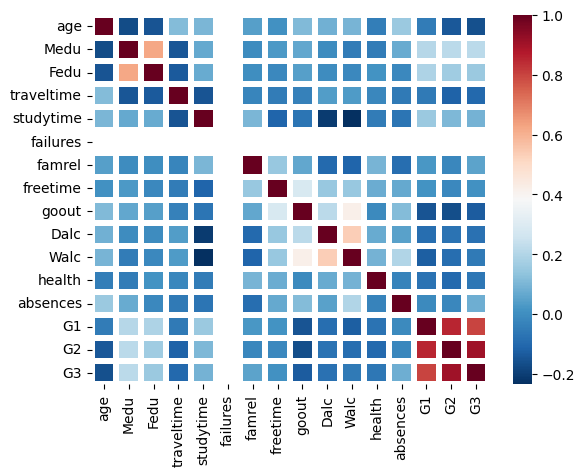

In [5]:
df_cor = numeric_df_completed.corr(method='pearson')
sns.heatmap(df_cor,
            xticklabels = df_cor.columns,
            yticklabels = df_cor.columns,
            cmap = 'RdBu_r',
            linewidth = 3)

## 범주형 데이터 수치형 변환 >> none 결측치 원복 >> 결측치 knn방식으로 대체

In [6]:
#catgory_df
cat_df = catgory_df.copy()
ncwe_cat = utils_numeric.NumericColsWEncoding(cat_df)
trf_cat_df = ncwe_cat.make_encoded_dataframe(cat_df)
null_cols = catgory_df.columns[catgory_df.isnull().sum() != 0]
null_cols_encd = [col+'_encd' for col in null_cols]

In [7]:
def dict_zip_data(dict_df, col1, col2):
    dict_data = dict_df[[col1,col2]]
    dict_data = dict_data.drop_duplicates()
    dict_col1 = dict_data[col1].values
    dict_col2 = dict_data[col2].values
    dict_zip_data = dict(zip(dict_col1, dict_col2))
    return dict_zip_data
    
def make_couple_df(data, col1, col2):
    coup_df = data[[col1, col2]]
    coup_df = coup_df.fillna('null_check')
    coup_idx = coup_df[coup_df[col1]=='null_check'].index
    coup_df.loc[coup_idx, col2] = None
    return coup_df
length = len(null_cols)
ls_df = []
ls_zip = []
null_catg_df = pd.DataFrame()
for i in range(length):
    col1 = null_cols[i]
    col2 = null_cols_encd[i]
    part_df = make_couple_df(cat_df, col1, col2)
    null_catg_df[col2] = part_df[col2].values
    ls_df.append(part_df)
    part_df = part_df.drop_duplicates()
    zip_df = dict_zip_data(part_df, col2, col1)
    ls_zip.append(zip_df)

In [13]:
# 1차결측치 검증
ncs_cat = utils_null.NullCheckSubstitution(null_catg_df)
null_cat_df_check = ncs_cat.null_check()
null_cat_df_check = null_cat_df_check.round(0)
# knn 대체 기준 값으로 기존 'null_check' 대응하는 기존 값을 삭제하고 기준 값으로 대체한다.
for col in null_cols_encd:
    cat_df[col] = null_cat_df_check[col].values
    trf_cat_df[col] = null_cat_df_check[col].values
# 매칭을 통해서 범주형을 채운다.
length = len(null_cols_encd)
for i in range(length):
    cat_df[null_cols[i]] = cat_df[null_cols_encd[i]].map(ls_zip[i])

본 결측치 체크는 연속형 변수에 대하여 진행합니다.
결측치 데이터 컬럼 없음!


In [18]:
catgory_df_completed = trf_cat_df.round(0)

In [19]:
all_numeric_trf_df = pd.concat([numeric_df_completed, catgory_df_completed], axis=1)
all_numeric_trf_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,address_encd,internet_encd,activities_encd,romantic_encd,sex_encd,school_encd,nursery_encd,Pstatus_encd,Mjob_encd,Fjob_encd,reason_encd,guardian_encd,paid_encd,schoolsup_encd,famsup_encd,famsize_encd,higher_encd
0,18.0,4,4,2.0,2.0,0.0,4,3,4,1.0,1,3,6.0,5,6,6,1,0,0,0,0,0,1,0,0.0,4.0,0.0,1.0,0,1,0,0,1
1,17.0,1,1,1.0,2.0,0.0,5,3,3,1.0,1,3,4.0,5,5,6,1,1,0,0,0,0,0,1,0.0,2.0,0.0,1.0,0,0,1,0,1
2,15.0,1,1,1.0,2.0,0.0,4,3,2,2.0,3,3,10.0,7,8,10,1,1,0,0,0,0,1,1,0.0,2.0,1.0,1.0,1,1,0,1,1
3,15.0,4,2,1.0,3.0,0.0,3,2,2,1.0,1,5,2.0,15,14,15,1,1,1,1,0,0,1,1,1.0,2.0,1.0,1.0,1,0,1,0,1
4,16.0,3,3,1.0,2.0,0.0,4,3,2,1.0,2,5,4.0,6,10,10,1,0,0,0,0,0,1,1,2.0,2.0,1.0,0.0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20.0,2,2,1.0,2.0,0.0,5,5,4,1.0,5,4,11.0,9,9,9,1,0,0,0,1,1,1,0,3.0,3.0,0.0,2.0,1,0,1,1,1
391,17.0,3,1,2.0,1.0,0.0,2,4,5,3.0,4,2,3.0,14,16,16,1,1,0,0,1,1,0,1,3.0,3.0,0.0,1.0,0,0,0,1,1
392,21.0,1,1,1.0,1.0,0.0,5,5,3,3.0,3,3,3.0,10,8,7,0,0,0,0,1,1,0,1,2.0,2.0,0.0,2.0,0,0,0,0,1
393,18.0,3,2,3.0,1.0,0.0,4,4,1,3.0,4,5,0.0,11,12,10,0,1,0,0,1,1,0,1,3.0,2.0,0.0,1.0,0,0,0,1,1
